# Results Deliverable 2

This notebook shows the results of the best models obtained using different techniques. 

It provides the evaluation metrics for the train and test sets and also the results required for the TEST\_SENTENCES.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from Spelling_Correction_c  import Spelling_Correction_c
import seaborn as sns
from matplotlib import cm

import skseq
from skseq.sequences import sequence
from skseq.sequences.sequence import Sequence
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary
import skseq.sequences.structured_perceptron as spc
from skseq.sequences import extended_feature
import time

## Loading the data

We load cleaned datasets containing the training and test data.

In [2]:
data_train = pd.read_csv("clean_train.csv")
data_test = pd.read_csv("clean_test.csv")

We build the X and Y data for both the training and tests sets.

In [11]:
%%time 
X_train = []
Y_train = []

curr_sent = 'Sentence: 1'
list_sent = []
list_y = []
for i in range(data_train.shape[0]):
    #print("current {}/{}".format(i,data_train.shape[0]), end="\r")
    if data_train["Sentence #"][i] == curr_sent:
        list_sent.append(data_train['Word'][i])
        list_y.append(data_train['Tag'][i])
    else:
        curr_sent = data_train["Sentence #"][i]
        X_train.append(list_sent)
        Y_train.append(list_y)
        list_sent = [data_train['Word'][i]]
        list_y = [data_train['Tag'][i]]
        
X_test = []
Y_test = []

curr_sent = 'Sentence: 35970'
list_sent = []
list_y = []
for i in range(data_test.shape[0]):
    #print("current {}/{}".format(i,data_test.shape[0]), end="\r")
    if data_test["Sentence #"][i] == curr_sent:
        list_sent.append(data_test['Word'][i])
        list_y.append(data_test['Tag'][i])
    else:
        curr_sent = data_test["Sentence #"][i]
        X_test.append(list_sent)
        Y_test.append(list_y)
        list_sent = [data_test['Word'][i]]
        list_y = [data_test['Tag'][i]]
        


CPU times: user 27.7 s, sys: 23.9 ms, total: 27.7 s
Wall time: 27.7 s


### Auxiliar functions

In [13]:
def build_word_to_pos(X):

    word_to_pos = {}
    i = 0
    for s in X:
        for w in s:
            if w not in word_to_pos:
                word_to_pos[w] = i
                i +=1
                
    pos_to_word = {v: k for k, v in word_to_pos.items()}
    return word_to_pos, pos_to_word
            
def build_tag_to_pos(Y):
    tag_to_pos = {}
    i = 0
    for s in Y:
        for t in s:
            if t not in tag_to_pos:
                tag_to_pos[t] = i
                i +=1
    pos_to_tag = {v: k for k, v in tag_to_pos.items()}

    return tag_to_pos, pos_to_tag



word_to_pos, pos_to_word = build_word_to_pos(X_train)
tag_to_pos, pos_to_tag  = build_tag_to_pos(Y_train)

def generate_sequence_list(X, y, word_to_pos, tag_to_pos):
    # Generate x and y dicts
    x_dict = LabelDictionary(word_to_pos.keys())
    y_dict = LabelDictionary(tag_to_pos.keys())
    # Generate SequenceList
    seq_list = SequenceList(x_dict, y_dict)
    # Add words/tags to sequencelist
    for i in range(len(X)):
        seq_list.add_sequence(X[i], y[i], x_dict, y_dict)
    return seq_list

train_seq = generate_sequence_list(X_train, Y_train, word_to_pos, tag_to_pos)


## Code to evaluate the metrics

We are going to evaluate the results according to the following metrics:

+ Accuracy on the train set and test set.

+ Confusion matrix on the train and test set.

+ Number of sentences without any label error in both train and test sets (for each sequence you score a 1 if all the words have the correct label and a zero otherwise).

+ The sentences from TEST_SENTENCES (look below) need to be used to evaluate yourwork (besides the accuracy, confusion matrix and number of sentences without any label error).

In [14]:
def accuracy_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    correct = 0.0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                correct += 1
            total += 1
    return correct / total


def accuracy_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    correct = 0.0
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                correct += 1
            total += 1
    return correct / total

In [15]:
tags = list(tag_to_pos.keys())

def confusion_matrix_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    confusion = np.zeros((len(tags), len(tags)))
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                confusion[y_hat, y_hat] +=1
            else:
                confusion[sequence.y[j], y_hat] +=1
            
    return confusion


def confusion_matrix_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    confusion = np.zeros((len(tags), len(tags)))
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                confusion[y_hat, y_hat] +=1
            else:
                confusion[tag_to_pos[ys[j]], y_hat] +=1      
    return confusion

In [16]:
def sentences_no_errors_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        n = len(pred.y)
        count = 0
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                count +=1
        if count == n:
            num_correct+=1
            
    return num_correct


def sentences_no_errors_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        n = len(pred.y)
        count = 0
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                count+=1
        if count==n:
            num_correct+=1
        
    return num_correct

In [25]:
def get_prediction_results():
    pred_test = []
    for i in range(len(X_test)):
        p = X_test[i]
        new_seq = skseq.sequences.sequence.Sequence(x=p, y=[int(0) for w in p])
        res = sp.viterbi_decode(new_seq)[0]
        pred_test.append(res)

    pred_train = sp.viterbi_decode_corpus(train_seq)
    
    return pred_test, pred_train
    
def get_prediction_acc(pred_train, pred_test):
    eval_train = accuracy_corpus(train_seq.seq_list, pred_train)
    eval_test = accuracy_predictions(Y_test, pred_test)
    return eval_train, eval_test

def show_confussion_images():
    eval_train = confusion_matrix_corpus(train_seq.seq_list, pred_train)
    eval_test = confusion_matrix_predictions(Y_test, pred_test)

    eval_train = pd.DataFrame(eval_train, columns =tags, index = tags)
    eval_test = pd.DataFrame(eval_test, columns =tags, index = tags)
    
    sns.heatmap(np.log(eval_train+1))
    plt.show()

    sns.heatmap(np.log(eval_test+1))
    plt.show()
    
    return eval_train, eval_test

In [26]:
sentences_test = [
    "The programmers from Barcelona might write a sentence without a spell checker.",
    "The programmers from Barchelona might write a sentence without a spell checker.",
    "Jack London went to Parris.",
    "Jack London went to Paris.",
    "We never though Microsoft would become such a big company.",
    "We never though Microsof would become such a big company.",
    "The president of U.S.A. though they would win the war",
    "The president of the United States of America though they could win the war",
    "The king of Saudi Arabia wanted total control.",
    "Robin does not want to go to Saudi Arabia.",
    "Apple is a great company.",
    "I really love apples and oranges."
]

sentences_seq_test = []
for p in sentences_test:
    sentences_seq_test.append(skseq.sequences.sequence.Sequence(x=p.split(), y=[int(0) for w in p.split()]))

## Model 1: Structured perceptron

The first type of model we designed to solve the name entity task is a linear discriminative sequence model built using a structured perceptron. 

Discriminative sequence models aim to solve the following:

$$\underset{y\,\in\,\Lambda^N}{\textrm{arg max}}\ P(Y=y\,|\,X=x)=\underset{y\,\in\,\Lambda^N}{\textrm{arg max}}\ \boldsymbol{w}\cdot\boldsymbol{f}(x, y)$$

where $\boldsymbol{w}$ is the model's weight vector, and $\boldsymbol{f}(x, y)$ is a feature vector.

In order to select the best features  $\boldsymbol{f}(x, y)$, we performed model selection in the notebook `ComparisonFeatures.ipnb` in a validation set. The features that we considered were the following:

+ **Closest word**: This feature aims to solve the spelling mistake issue. Given a word `w`, it finds the closest word `w\_sim` belonging to an existing dictionary. If the `w` already belongs to the vocabulary, `w\_sim = w`. The feature has the form `closestWord:w\_sim::dist` where `dist`=distance(`w`, `w\_sim`). 

+ **Suffix**: Checks if the word has a suffix from this list: `['an', 'ian', 'ine', 'ite', 'er', 'eno', 'ish', 'ese', 'i', 'ic', 'iote']`. This feature aims to detect demonyms. The feature has the form `suffix:suffix_name::tag`.

+ **Capitalized**: Whether the word is capitalized or not. The feature has the form `capitalized:tag`.

+ **Uppercase**: Whether all the letters of the word are uppercase. The feature has the form `uppercase:tag`.

+ **Dot**: Whether the word contains dots. The feature is of the form `Dot:tag`.

+ **Hyphen**: Whether the word contains a hyphen. The feature is of the form `Hyphen:tag`.

+ **Numeric**: Whether the string is all numeric. The feature is of the form `Numeric:num\_digits::tag`, where `num\_digits` is the number of digits of the word.

+ **LettersNumbers**: Whether the word contains letters and numbers. The feature is of the form `LettersNumbers:tag`.

+ **DaysWeek**: Whether the word ends with -day. The feature is of the form `DaysWeek:tag`.


After performing feature selection with these features, we found that the best combination was to select only **Closest word + Suffix**. Here we show the performance of such model.


In [18]:
words = list(word_to_pos.keys())
spelling = Spelling_Correction_c(words, tol = 1)

feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = True, capitalized = False,
                                                                  uppercase = False, Dot = False,
                                                                  Hyphen = False, Numeric = False,
                                                                  LettersNumbers = False, DaysWeek = False)
feature_mapper.build_features() #get the features

In [20]:
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
sp.load_model(dir="./comparison_features/comparison_extended_features_2")

### Accuracy on train and test set



In [27]:
pred_test, pred_train = get_prediction_results()
eval_train, eval_test = get_prediction_acc(pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Test: %.4f"%(eval_train, eval_test))

SP -  Accuracy Train: 0.0309 Test: 0.0307


### Confusion matrix on the train and test set

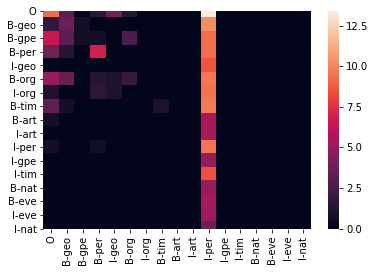

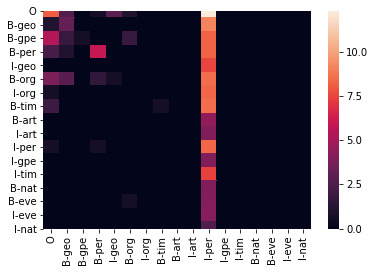

In [28]:
conf_train, conf_test= show_confussion_images()

In [29]:
print("Confusion matrix train")
conf_train

Confusion matrix train


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,B-art,I-art,I-per,I-gpe,I-tim,B-nat,B-eve,I-eve,I-nat
O,10202.0,23.0,0.0,4.0,53.0,3.0,0.0,0.0,0.0,0.0,656120.0,0.0,0.0,0.0,0.0,0.0,0.0
B-geo,5.0,39.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28128.0,0.0,0.0,0.0,0.0,0.0,0.0
B-gpe,653.0,23.0,1.0,1.0,0.0,14.0,0.0,0.0,0.0,0.0,11100.0,0.0,0.0,0.0,0.0,0.0,0.0
B-per,46.0,3.0,0.0,1094.0,0.0,0.0,0.0,0.0,0.0,0.0,11613.0,0.0,0.0,0.0,0.0,0.0,0.0
I-geo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5581.0,0.0,0.0,0.0,0.0,0.0,0.0
B-org,157.0,36.0,0.0,3.0,2.0,6.0,0.0,0.0,0.0,0.0,14866.0,0.0,0.0,0.0,0.0,0.0,0.0
I-org,2.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,12535.0,0.0,0.0,0.0,0.0,0.0,0.0
B-tim,27.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,15213.0,0.0,0.0,0.0,0.0,0.0,0.0
B-art,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,311.0,0.0,0.0,0.0,0.0,0.0,0.0
I-art,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,244.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
print("Confusion matrix test")
conf_test

Confusion matrix test


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,B-art,I-art,I-per,I-gpe,I-tim,B-nat,B-eve,I-eve,I-nat
O,3363.0,12.0,0.0,1.0,18.0,2.0,0.0,0.0,0.0,0.0,218065.0,0.0,0.0,0.0,0.0,0.0,0.0
B-geo,2.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9445.0,0.0,0.0,0.0,0.0,0.0,0.0
B-gpe,226.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3838.0,0.0,0.0,0.0,0.0,0.0,0.0
B-per,9.0,2.0,0.0,394.0,0.0,0.0,0.0,0.0,0.0,0.0,3828.0,0.0,0.0,0.0,0.0,0.0,0.0
I-geo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1833.0,0.0,0.0,0.0,0.0,0.0,0.0
B-org,46.0,16.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,5005.0,0.0,0.0,0.0,0.0,0.0,0.0
I-org,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4240.0,0.0,0.0,0.0,0.0,0.0,0.0
B-tim,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5083.0,0.0,0.0,0.0,0.0,0.0,0.0
B-art,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0
I-art,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0


### Number of sentences without any label error in both train and test sets 

In [31]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f  Test: %.0f"%(len(pred_train),len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0fTest: %.0f"%(eval_train, eval_test))

SP - Number of sentences Train: 35967  Test: 11989
SP - Number of sentences wihtout error Train: 1Test: 1


###  Sentences from TEST_SENTENCES

In [32]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True), '\n')

The/O programmers/I-per from/I-per Barcelona/I-per might/I-per write/I-per a/I-per sentence/I-per without/I-per a/I-per spell/I-per checker./I-per  

The/O programmers/I-per from/I-per Barchelona/I-per might/I-per write/I-per a/I-per sentence/I-per without/I-per a/I-per spell/I-per checker./I-per  

Jack/I-per London/I-per went/I-per to/I-per Parris./I-per  

Jack/I-per London/I-per went/I-per to/I-per Paris./I-per  

We/I-per never/I-per though/I-per Microsoft/I-per would/I-per become/I-per such/I-per a/I-per big/I-per company./I-per  

We/I-per never/I-per though/I-per Microsof/I-per would/I-per become/I-per such/I-per a/I-per big/I-per company./I-per  

The/O president/I-per of/I-per U.S.A./I-per though/I-per they/I-per would/I-per win/I-per the/I-per war/I-per  

The/O president/I-per of/I-per the/I-per United/I-per States/I-per of/I-per America/I-per though/I-per they/I-per could/I-per win/I-per the/I-per war/I-per  

The/O king/I-per of/I-per Saudi/I-per Arabia/I-per wanted/I-per